In [1]:
import os, sys, importlib, logging, random, traceback

import numpy as np
import pandas as pd
import scipy as sp
from scipy.interpolate import griddata, RBFInterpolator
from scipy.spatial import cKDTree

from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from matplotlib.path import Path
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import seaborn as sns
sns.set_theme()

from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
proj_3413 = ccrs.epsg(3413)

import netCDF4

import gstatsim as gs
import gstatsim_custom as gsim
from gstatsim_custom import interpolate
importlib.reload(interpolate)

# Logging setup (tweak level/format as needed)
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s -%(levelname)s -on line: %(lineno)d -%(message)s')
# logger = logging.getLogger('name')

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3413") # transformer from WGS84 to Polar ICE
transformer_revert = Transformer.from_crs("EPSG:3413", "EPSG:4326") # transformer from WGS84 to Polar ICE

In [2]:
core3_df = pd.read_csv('data/3cores.csv')
X_ls = []
Y_ls = []
for i in range(len(core3_df)):
    y_coord, x_coord = float(core3_df.at[i, 'lon']), float(core3_df.at[i, 'lat'])
    x_trans, y_trans = transformer.transform(x_coord, y_coord)
    print(x_trans, y_trans)
    X_ls.append(x_trans)
    Y_ls.append(y_trans)
core3_df['X'] = X_ls
core3_df['Y'] = Y_ls

-2455220.3799470863 -38000.81804313284
-2371888.528769009 -52445.09291899725
-2278114.069881762 13551.881451109522
-2277803.2021601065 13583.189167793638
-2257659.5402246974 117803.06274523145


In [3]:
transects = pd.read_csv('data/delta_transects.csv')
transect = transects[transects['id']==2]

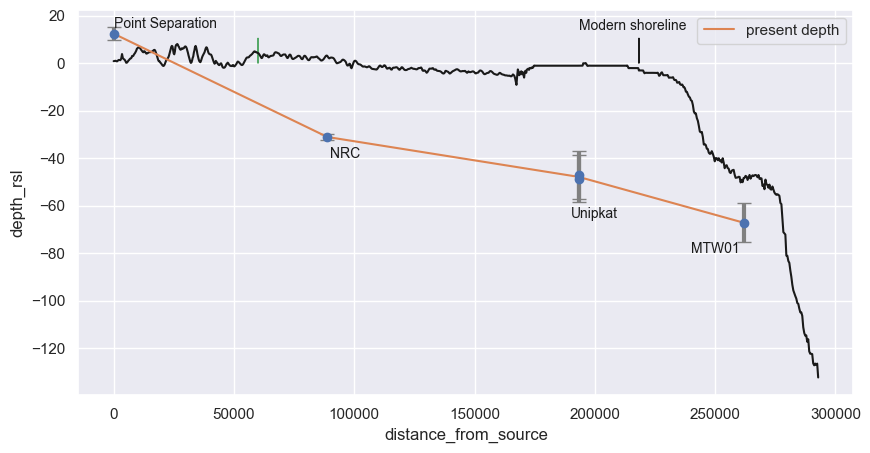

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(transect['dist_km']*1000, transect['Z'],c='k')
ax.errorbar(core3_df['distance_from_source'], core3_df['depth_rsl'], yerr=core3_df['elevation_error'],
            ecolor='grey', elinewidth=3,fmt='o',capsize=5)
sns.lineplot(x='distance_from_source', y='depth_rsl',data=core3_df, ax=ax, label="present depth")
# sns.lineplot(x='distance_from_source', y='corrected_elevation',data=core3_df, ax=ax, label="GIA corrected")
ax.text(0, 15, 'Point Separation', fontsize=10, color='k')
ax.text(90000, -40, 'NRC', fontsize=10, color='k')
ax.text(190000, -65, 'Unipkat', fontsize=10, color='k')
ax.text(240000, -80, 'MTW01', fontsize=10, color='k')
ax.text(core3_df['distance_from_source'][3], 14, 'Modern shoreline', fontsize=10, color='k')
ax.arrow(core3_df['distance_from_source'][3]+25000, 0, 10, 10, head_width=1, head_length=1, fc='k', ec='k')
# ax.text(51000, 14, '~Paleo shoreline 7.5KBP', fontsize=10, color='g')
ax.arrow(60000, 0, 10, 10, head_width=1, head_length=1, fc='g', ec='g')


# plt.grid(axis='x')

In [87]:
fig.savefig("analysis_transect.png", dpi=300, bbox_inches='tight')

# Resampling and creating a uniform grid

The following section is for preparing topo data with customized resolution for plotting and data interpolating

In [5]:
topo = pd.read_csv('data/combined_topo_bathy.csv')
with netCDF4.Dataset('data/Gi31_H_grid.nc', 'r') as ds:
    time = ds.variables['time'][:]
    time_index = np.where((time == 7.5))[0][0]
    RSL = ds.variables['RSL'][:][time_index].T
    R = ds.variables['R_latlong'][:][time_index].T
    lon = ds.variables['lon'][:]
    lat = ds.variables['lat'][:]
lon_grid, lat_grid = np.meshgrid(lon, lat)
print(RSL.shape)
lon_min, lon_max = 200, 250
lat_min, lat_max = 62, 75

(256, 512)


In [6]:
ymin, ymax = min(topo['Y']), max(topo['Y'])
xmin, xmax = min(topo['X']), max(topo['X'])
coord1 = transformer_revert.transform(xmin,ymin)
coord2 =  transformer_revert.transform(xmax,ymax)
Ylim = [ymin,ymax]
Xlim = [xmin,xmax]
print(Ylim)
print(Xlim)
print(coord1)
print(coord2)
# creating uniform grid
res = 300
x = np.linspace(Xlim[0], Xlim[1], res)
y = np.linspace(Ylim[0], Ylim[1], res)
X,Y = np.meshgrid(x, y)

[-173176.037, 178831.926]
[-2541984.99, -2126921.783]
(66.78970604456018, -131.10267239633112)
(70.47990090425097, -139.80613402736836)


In [7]:
# Flatten the topo grid and Z data for interpolation
points = np.column_stack((topo['X'].to_numpy(), topo['Y'].to_numpy()))
values = topo['Z'].to_numpy()
topo_interpolated = griddata(points, values, (X, Y), method='cubic')

points = np.column_stack((core3_df['X'].to_numpy(), core3_df['Y'].to_numpy()))
values = core3_df['depth_rsl'].to_numpy()
core3_interpolated = griddata(points, values, (X, Y), method='linear')

lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()
x_flat, y_flat = transformer.transform(lat_flat, lon_flat)
x_grid = x_flat.reshape(lon_grid.shape)
y_grid = y_flat.reshape(lat_grid.shape)
points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
values = RSL.ravel()
RSL_interpolated = griddata(points, values, (X, Y), method='cubic')

In [8]:
points = np.column_stack((X.ravel(), Y.ravel()))
values = RSL_interpolated.ravel()
tree = cKDTree(points)
queries = np.column_stack([core3_df['X'], core3_df['Y']])
d, idx = tree.query(queries, k=1)
correction = values[idx]
core3_df['corrected_elevation'] = core3_df['depth_rsl'] - correction
# print(correction)

In [35]:
points = np.column_stack((core3_df['X'].to_numpy(), core3_df['Y'].to_numpy()))
values = core3_df['corrected_elevation'].to_numpy()
core3_corrected_interpolated = griddata(points, values, (X, Y), method='linear')

points = np.column_stack((X.ravel(), Y.ravel()))
values = core3_corrected_interpolated.ravel()
core3_corrected_interpolated_1 = griddata(points, values, (X, Y), method='nearest')

In [11]:
def demo_locatable_axes_easy(ax, im):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax)

    ax_cb = divider.append_axes("right", size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    # Z, extent = get_demo_image()
    # im = ax.imshow(Z, extent=extent)

    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()
    ax_cb.yaxis.set_tick_params(labelright=True)

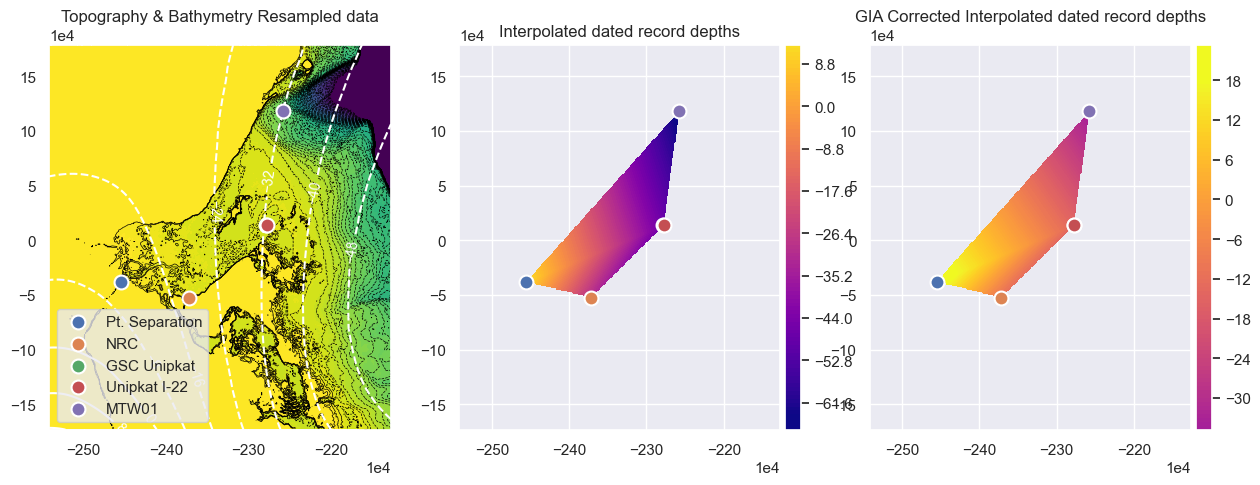

In [12]:
%matplotlib inline
# from matplotlib.ticker import ScalarFormatter
# fig, ax = plt.subplots(figsize=(10,10))
vmin = -200
vmax= 10
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].contourf(X, Y, topo_interpolated, 1000,cmap='viridis', vmin=vmin, vmax=vmax, zorder=1)
ax[0].contour(X, Y, topo_interpolated, levels=np.linspace(vmin, vmax, 50), colors='black', linewidths=0.5, zorder=2)
cs = ax[0].contour(X,Y,RSL_interpolated,10, colors='w')
im = ax[1].contourf(X,Y,core3_interpolated,100, cmap='plasma', vmin=-64, vmax=18)
im1 = ax[2].contourf(X,Y,core3_corrected_interpolated,100, cmap='plasma',vmin=-64, vmax=18)
for i in range(len(core3_df)):
    ax[0].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[1].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[2].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
    ax[1].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
    ax[2].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
ax[0].clabel(cs, fontsize=10)
ax[0].set_title('Topography & Bathymetry Resampled data')
ax[1].set_title('Interpolated dated record depths')
ax[2].set_title('GIA Corrected Interpolated dated record depths')
demo_locatable_axes_easy(ax[1], im)
demo_locatable_axes_easy(ax[2], im1)

ax[0].legend(loc='lower left')


fig.show()

# Using Gstatsim for Bedmap interpolation

The following section will set up conditioning data and statistically simulate the outer perimiter GIA corrected to create a base topography.

The base topography will then be masked and subtracted from the present topo to estimate the sediment volume

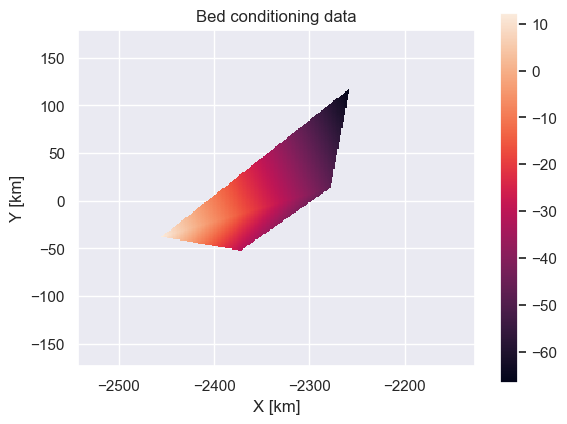

In [13]:
# re using plotted data above to clearly define matrices that we will use
xx,yy = X,Y
bed_cond = core3_interpolated
plt.pcolormesh(x/1000, y/1000, bed_cond)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bed conditioning data')
plt.colorbar()
plt.show()


In [15]:
cond_msk = ~np.isnan(bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]

smoothing = 1e3
interp = RBFInterpolator(np.array([x_cond, y_cond]).T, data_cond, smoothing=smoothing)
trend = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
res_cond = bed_cond - trend

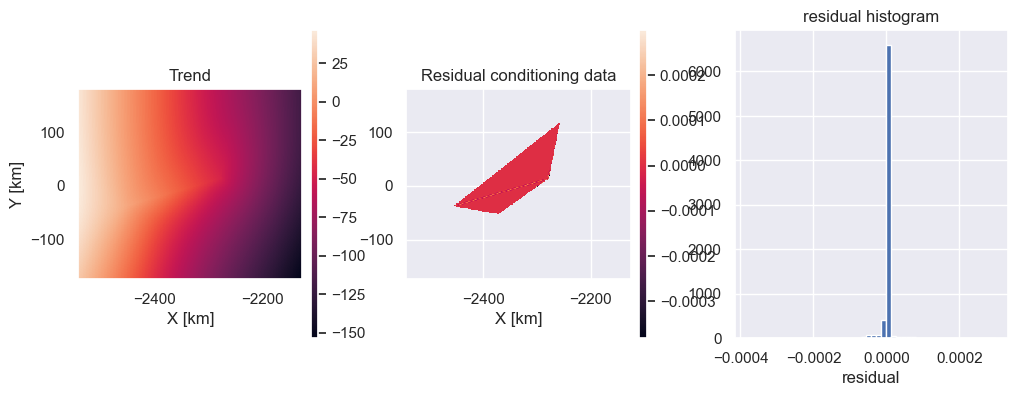

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
ax = axs[0]
im = ax.pcolormesh(x/1000, y/1000, trend)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(x/1000, y/1000, res_cond)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Residual conditioning data')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
ax.hist(res_cond[cond_msk], bins=50)
ax.set_xlabel('residual')
ax.set_title('residual histogram')

plt.show()

In [17]:
res_norm, nst_trans = gsim.utilities.gaussian_transformation(res_cond, cond_msk)
df_grid = pd.DataFrame({'X' : x_cond, 'Y' : y_cond, 'residual' : res_cond[cond_msk], 'NormZ' : res_norm[cond_msk]})

In [18]:
vgrams, experimental, bins = gsim.utilities.variograms(xx, yy, res_cond, maxlag=30e3, n_lags=10, downsample=5)

In [19]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

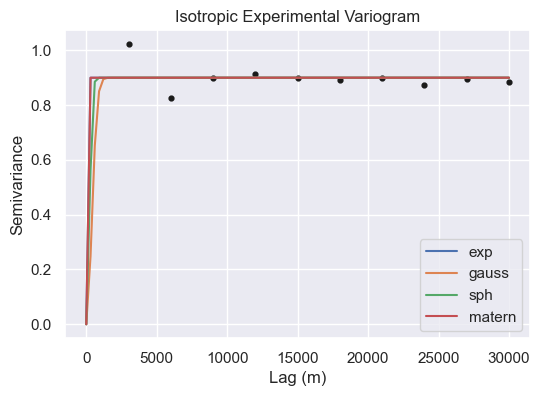

In [20]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [21]:
vgrams['matern']

[np.float64(46.11755482767421),
 np.float64(0.8993527988657893),
 np.float64(18.945722974667568),
 0]

In [22]:
parameters = vgrams['matern']

# set variogram parameters
nugget = parameters[-1]
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
nugget = parameters[-1]
azimuth = 0

In [23]:
rng = np.random.default_rng(0)

k = 10
rad = 240e3

In [24]:
vario = {
    'azimuth' : azimuth,
    'nugget' : nugget,
    'major_range' : major_range,
    'minor_range' : minor_range,
    'sill' : sill,
    's' : smoothness,
    'vtype' : 'matern',
}

res_newsim = gsim.interpolate.sgs(xx, yy, res_cond, vario, rad, k, seed=0)

  0%|          | 0/90000 [00:00<?, ?it/s]

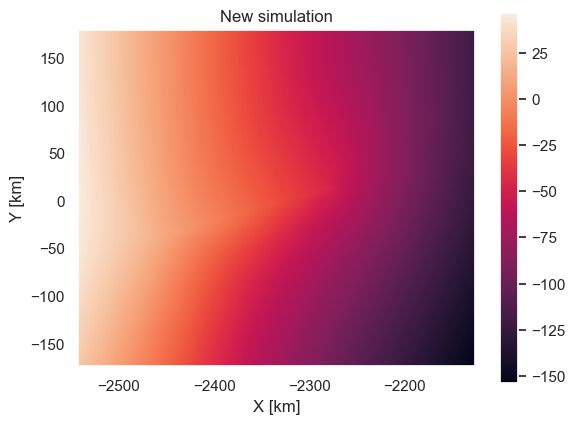

In [25]:
plt.pcolormesh(x/1000, y/1000, res_newsim + trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('New simulation')
plt.colorbar()
plt.show()

In [ ]:
bed_gsm = res_newsim + trend
df_boundary = pd.read_csv('data/mackenzie-boundary.csv')
delta = df_boundary[df_boundary['id'] == 2]
offshore = df_boundary[df_boundary['id'] == 7]
mask1 = Path(np.column_stack((delta['X'],delta['Y'])))
mask2 = Path(np.column_stack((offshore['X'],offshore['Y'])))
inside_delta = mask1.contains_points(points)
inside_shore = mask2.contains_points(points)
inside_combined = np.logical_or(inside_delta, inside_shore)
bed_raveled = bed_gsm.ravel()
topo_raveled = topo_interpolated.ravel()
masked_bed_sim = bed_raveled[inside_combined]
masked_topo = topo_raveled[inside_combined]
masked_coords = points[inside_combined]

sediment_thickness = masked_topo - masked_bed_sim
filtered_H_thickness = np.where(sediment_thickness < 0, np.nan, sediment_thickness)

full_mask = np.full(xx.shape, False)
coord_to_index = {tuple(coord): i for i, coord in enumerate(points)}
for coord in masked_coords:
    idx = coord_to_index[tuple(coord)]
    row = idx // xx.shape[1]
    col = idx % xx.shape[1]
    full_mask[row, col] = True

masked_topo_interpolated = np.where(full_mask, topo_interpolated, np.nan)

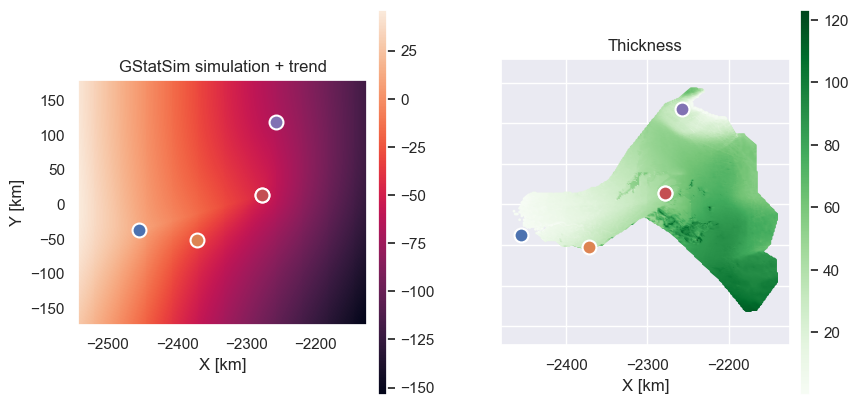

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1 = axs[0]
im = ax1.pcolormesh(x/1000, y/1000, bed_gsm)
ax1.axis('scaled')
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_title('GStatSim simulation + trend')
plt.colorbar(im, ax=ax1, pad=0.03, aspect=40)

ax2 = axs[1]
im1 = ax2.scatter(masked_coords[:, 0]/1000, masked_coords[:, 1]/1000, c=filtered_H_thickness, cmap='Greens', s=1)

# ax2.plot(delta['X']/1000, delta['Y']/1000, color='green', linewidth=1)
# ax2.plot(offshore['X']/1000, offshore['Y']/1000, color='green', linewidth=1)
ax2.axis('scaled')
ax2.set_xlabel('X [km]')
ax2.set_title('Thickness')
for i in range(len(core3_df)):
    ax1.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax2.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])

plt.colorbar(im1, ax=ax2, pad=0.03, aspect=40)
plt.show()

In [33]:
k = 10
rad = 10e3
sim_partial = gsim.interpolate.sgs(xx, yy, bed_cond, vario, rad, k, sim_mask=full_mask, seed=rng)

  0%|          | 0/23862 [00:00<?, ?it/s]

In [62]:
# Calculate sediment thickness using sim_partial and masked_topo_interpolated
thickness_partial = masked_topo_interpolated - (sim_partial+trend)

# Set negative thickness to zero
filtered_H_thickness_mask = np.where(thickness_partial < 0, np.nan, thickness_partial)

In [35]:
filtered_H_thickness_mask

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(300, 300))

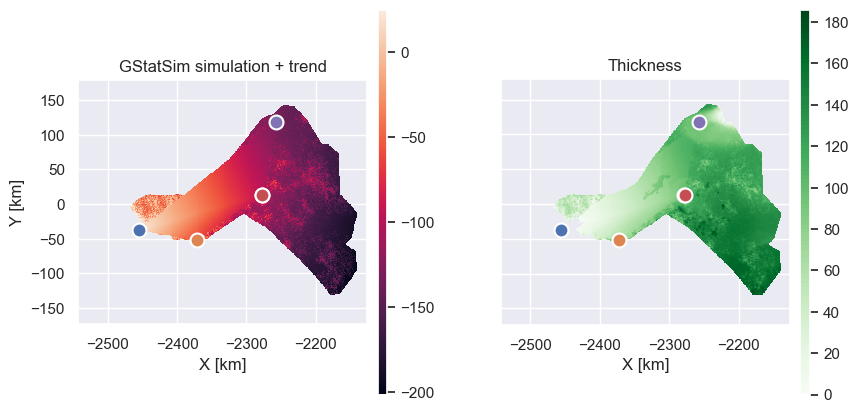

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1 = axs[0]
im = ax1.pcolormesh(x/1000, y/1000, sim_partial + trend)
ax1.axis('scaled')
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_title('GStatSim simulation + trend')
plt.colorbar(im, ax=ax1, pad=0.03, aspect=40)

ax2 = axs[1]
im1 = ax2.contourf(x/1000, y/1000, filtered_H_thickness_mask, levels=100, cmap='Greens')

# ax2.plot(delta['X']/1000, delta['Y']/1000, color='green', linewidth=1)
# ax2.plot(offshore['X']/1000, offshore['Y']/1000, color='green', linewidth=1)
ax2.axis('scaled')
ax2.set_xlabel('X [km]')
ax2.set_title('Thickness')
for i in range(len(core3_df)):
    ax1.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax2.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])

plt.colorbar(im1, ax=ax2, pad=0.03, aspect=40)
plt.show()

In [64]:
# how about just using the RBF trend for this?
masked_rbf_trend = np.where(full_mask, trend, np.nan) 
rbf_trend_sediment_thickness = masked_topo_interpolated - masked_rbf_trend
rbf_trend_sediment_thickness = np.where(rbf_trend_sediment_thickness < 0, np.nan, rbf_trend_sediment_thickness)

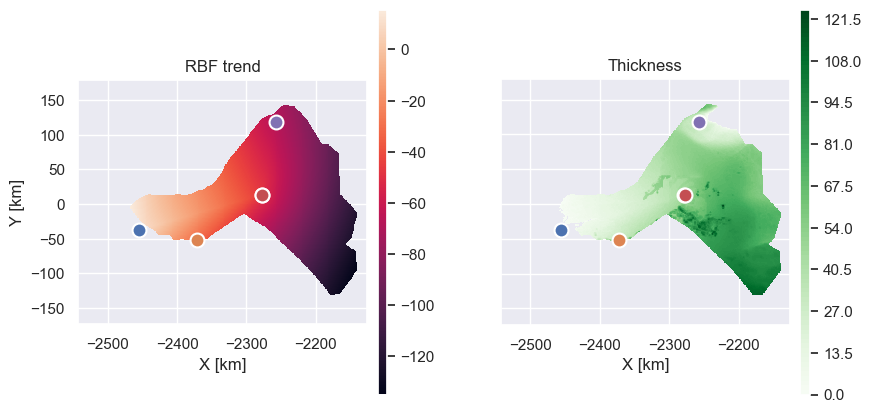

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1 = axs[0]
im = ax1.pcolormesh(x/1000, y/1000, masked_rbf_trend)
ax1.axis('scaled')
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_title('RBF trend')
plt.colorbar(im, ax=ax1, pad=0.03, aspect=40)

ax2 = axs[1]
im1 = ax2.contourf(x/1000, y/1000, rbf_trend_sediment_thickness, levels=100, cmap='Greens')

# ax2.plot(delta['X']/1000, delta['Y']/1000, color='green', linewidth=1)
# ax2.plot(offshore['X']/1000, offshore['Y']/1000, color='green', linewidth=1)
ax2.axis('scaled')
ax2.set_xlabel('X [km]')
ax2.set_title('Thickness')
for i in range(len(core3_df)):
    ax1.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax2.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])

plt.colorbar(im1, ax=ax2, pad=0.03, aspect=40)
plt.show()

# Estimate total sediment volume

In [66]:
V_estimated = np.nansum(filtered_H_thickness)
V_masked_estimated = np.nansum(filtered_H_thickness_mask)
V_masked_rbf_trend = np.nansum(rbf_trend_sediment_thickness)

print(f"V_total = {V_estimated} m^3")
print(f"V_total (masked sgs) = {V_masked_estimated} m^3")
print(f"V_total (only base rbf trend) = {V_masked_rbf_trend} m^3")

print(f"Yearly sedimentation past 7.5KBP= {V_estimated/7500} m^3/yr")
print(f"Yearly sedimentation past 7.5KBP (from mask)= {V_masked_estimated/7500} m^3/yr")

V_total = 1263469.0950596316 m^3
V_total (masked sgs) = 2362206.042242259 m^3
V_total (only base rbf trend) = 1263469.5843905113 m^3
Yearly sedimentation past 7.5KBP= 168.4625460079509 m^3/yr
Yearly sedimentation past 7.5KBP (from mask)= 314.9608056323012 m^3/yr


# Introducing perimeter data

These extra near vicinity and further offshore help to contrains the interpolation.

In [15]:
perimeter_cores = pd.read_csv('data/perimeter_cores.csv')
X_ls = []
Y_ls = []
for i in range(len(perimeter_cores)):
    y_coord, x_coord = float(perimeter_cores.at[i, 'lon']), float(perimeter_cores.at[i, 'lat'])
    x_trans, y_trans = transformer.transform(x_coord, y_coord)
    print(x_trans, y_trans)
    X_ls.append(x_trans)
    Y_ls.append(y_trans)
perimeter_cores['X'] = X_ls
perimeter_cores['Y'] = Y_ls
perimeter_cores

-2277958.7344262875 13550.9574027023
-2258121.8033671314 -2112.899141245659
-2212431.0719770663 -19404.136366805844
-2215300.7268185862 -16606.62430328788
-2211429.6432472775 -10723.413113135974
-2156250.354409331 -101256.51323420524
-2132035.9272506316 25428.74184224726
-2137067.0008142665 160979.30379432696


,name,lat,lon,dated_depth,depth_rsl,elevation_error,dated_year,dated_error,X,Y
0,GSC Kumak,69.193611,-135.340833,30.000,-30.000,10.00,NaN,NaN,-2.277959e+06,13550.957403
1,GSC Taglu,69.371389,-134.946389,10.000,-10.000,5.00,NaN,NaN,-2.258122e+06,-2112.899141
2,BH38,69.779670,-134.497500,-12.550,-17.550,NaN,10688.5,112.5,-2.212431e+06,-19404.136367
3,BH34,69.754170,-134.570500,-0.230,-4.230,NaN,6355.0,59.0,-2.215301e+06,-16606.624303
4,BH15,69.789170,-134.722170,-0.205,-20.205,0.00,3800.5,103.5,-2.211430e+06,-10723.413113
5,Uviluk P-66,70.262746,-132.311392,-1.040,-30.000,NaN,25894.0,867.0,-2.156250e+06,-101256.513234
6,Kopanoar I-44,70.500000,-135.683333,-0.800,-58.800,NaN,18400.0,NaN,-2.132036e+06,25428.741842
7,2002MR_K05_PC01,70.401863,-139.307796,-7.050,-678.050,0.01,11040.0,136.0,-2.137067e+06,160979.303794


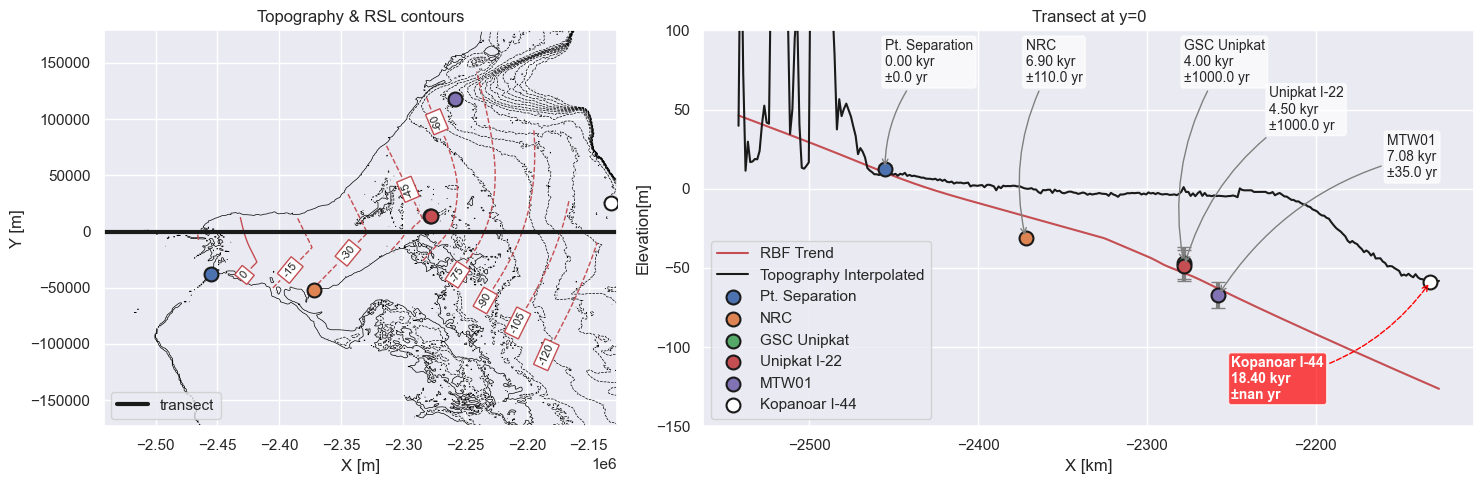

In [178]:
from matplotlib.gridspec import GridSpec

y0_idx = np.argmin(np.abs(y - 0))

transect_x = x  # x-coordinates
transect_rbf = trend[y0_idx, :]
transect_sgs_trend = bed_gsm[y0_idx, :]
transect_sgs_trend_masked = sim_partial[y0_idx, :] + trend[y0_idx, :]
transect_topo = topo_interpolated[y0_idx, :]

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 2, width_ratios=[1, 1.5])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax = [ax0, ax1]

# Left subplot: topo_interpolated and RSL_interpolated contours
# im0 = ax[0].contourf(X, Y, topo_interpolated, 1000, cmap='Greys_r', vmin=vmin, vmax=vmax, zorder=1, alpha=0.5)
ax[0].contour(X, Y, topo_interpolated, levels=np.linspace(vmin, vmax, 15), colors='black', linewidths=0.5, zorder=2)
cs = ax[0].contour(X, Y, masked_rbf_trend, 10, colors='r',linewidths=1)
ax[0].axhline(0, color='k', linestyle='-', linewidth=3, label='transect')
ax[0].clabel(cs, fontsize=8, fmt='%1.0f', inline=True, colors='k', rightside_up=False)
for txt in cs.labelTexts:
    txt.set_bbox(dict(facecolor='white', edgecolor='r', pad=2))
ax[0].scatter(perimeter_cores['X'][6],perimeter_cores['Y'][6], zorder=3,edgecolor='k',facecolor='w', s=100,linewidth=1.5)
ax[0].set_title('Topography & RSL contours')
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].legend(loc='lower left')
# plt.colorbar(im0, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)

# Right subplot: transect at y=0
ax1 = ax[1]
ax1.plot(transect_x / 1000, transect_rbf, label='RBF Trend', c='r')
# ax1.plot(transect_x / 1000, transect_sgs_trend, label='RBF Trend + Gsim', c='pink')
# ax1.plot(transect_x / 1000, transect_sgs_trend_masked, label='RBF Trend + maskedGsim', c='pink', linestyle='--')
ax1.plot(transect_x / 1000, transect_topo, label='Topography Interpolated', c='k')
ax1.errorbar(core3_df['X']/1000, core3_df['depth_rsl'], yerr=core3_df['elevation_error'],
             ecolor='grey', elinewidth=3, fmt='o', capsize=5, zorder=1)
for i in range(5):
    ax1.scatter(core3_df['X'][i]/1000, core3_df['depth_rsl'][i], zorder=3, edgecolor='k', s=100, linewidth=1.5, label=core3_df['name'][i])
    ax[0].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='k', s=100,linewidth=1.5, label=core3_df['name'][i])
    if i <= 1:
        ax1.annotate(
            f"{core3_df['name'][i]}\n{core3_df['dated_year'][i]/1000:.2f} kyr\n±{core3_df['error'][i]:.1f} yr",
            xy=(core3_df['X'][i]/1000, core3_df['depth_rsl'][i]),
            xycoords='data',
            xytext=(core3_df['X'][i]/1000, 80),
            textcoords='data',
            fontsize=10,
            va="center", ha="left",
            bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.7),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='gray')
        )
    else:
        ax1.annotate(
            f"{core3_df['name'][i]}\n{core3_df['dated_year'][i]/1000:.2f} kyr\n±{core3_df['error'][i]:.1f} yr",
            xy=(core3_df['X'][i]/1000, core3_df['depth_rsl'][i]),
            xycoords='data',
            xytext=(core3_df['X'][i]/1000+(i-2)*50, 80-30*(i-2)),
            textcoords='data',
            fontsize=10,
            va="center", ha="left",
            bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.7),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='gray')
        )
ax1.scatter(perimeter_cores['X'][6]/1000,perimeter_cores['depth_rsl'][6], zorder=3,edgecolor='k',facecolor='w', s=100,linewidth=1.5, label=perimeter_cores['name'][6])
ax1.annotate(
    f"{perimeter_cores['name'][6]}\n{perimeter_cores['dated_year'][6]/1000:.2f} kyr\n±{perimeter_cores['dated_error'][6]:.1f} yr",
    xy=(perimeter_cores['X'][6]/1000, perimeter_cores['depth_rsl'][6]),
    xycoords='data',
    xytext=(-2250, -120),
    textcoords='data',
    fontsize=10,
    color='w',
    weight='bold',
    va="center", ha="left",
    bbox=dict(boxstyle="round,pad=0.2", fc="red", alpha=0.7),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='red', linestyle='--')
)
ax1.set_ylim(-150, 100)
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Elevation[m]')
ax1.set_title('Transect at y=0')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

# Issue arised

If you look at the transect at y = 0, the offshore location is not intersecting with the topography interpolated. Without intersection the sediment subtraction will artificially creating a discontinued hiatus or the offshore location. As seen in figure above, we have Kopanoar I-44 (white circle) dated near surface of sea bed to be 18KBP, so the RBF Trend transect could not be lower near that point.

The introduction a couple of data points in the offshore region and region around Kendall Bird island would forcing the the sub surface simulation slope to intersect with the bathymetry data.

In [61]:
# filtered_core_names = ['Uviluk P-66', 'Kopanoar I-44', '2002MR_K05_PC01']
filtered_core_names = ['Uviluk P-66','Kopanoar I-44']
filtered_perimeter_cores = perimeter_cores[perimeter_cores['name'].isin(filtered_core_names)].reset_index(drop=True)
points = np.column_stack((core3_df['X'].to_numpy(), core3_df['Y'].to_numpy()))
perimeter_points = np.column_stack((filtered_perimeter_cores['X'].to_numpy(), filtered_perimeter_cores['Y'].to_numpy()))
points = np.vstack([points, perimeter_points])
values = np.concatenate([core3_df['depth_rsl'].to_numpy(), filtered_perimeter_cores['depth_rsl'].to_numpy()])
newcore_interpolated = griddata(points, values, (X, Y), method='linear')

In [62]:
filtered_perimeter_cores

,name,lat,lon,dated_depth,depth_rsl,elevation_error,dated_year,dated_error,X,Y
0,Uviluk P-66,70.262746,-132.311392,-1.04,-30.0,NaN,25894.0,867.0,-2.156250e+06,-101256.513234
1,Kopanoar I-44,70.500000,-135.683333,-0.80,-58.8,NaN,18400.0,NaN,-2.132036e+06,25428.741842


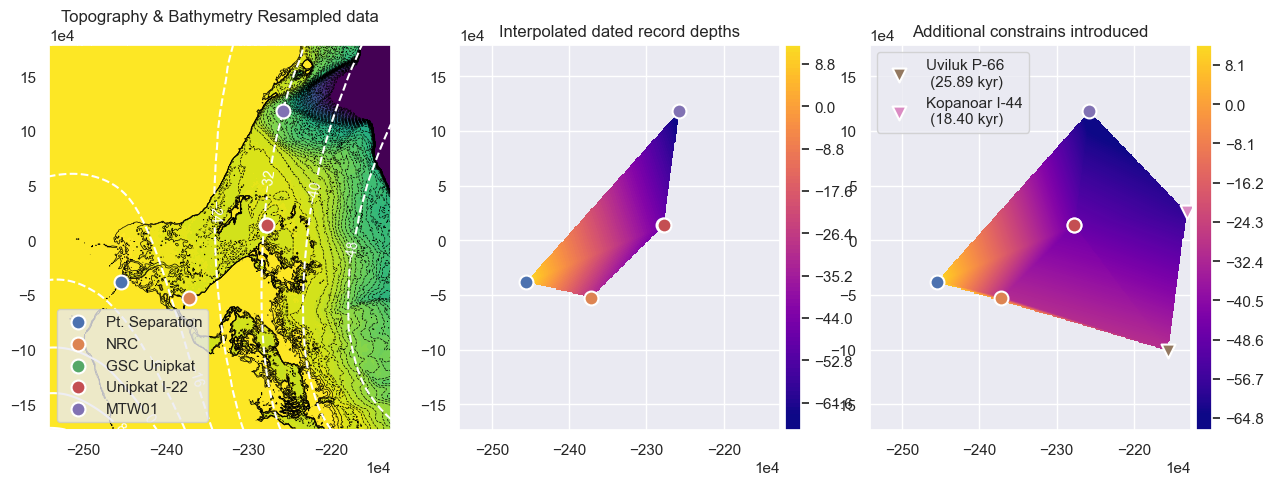

In [63]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].contourf(X, Y, topo_interpolated, 1000,cmap='viridis', vmin=vmin, vmax=vmax, zorder=1)
ax[0].contour(X, Y, topo_interpolated, levels=np.linspace(vmin, vmax, 50), colors='black', linewidths=0.5, zorder=2)
cs = ax[0].contour(X,Y,RSL_interpolated,10, colors='w')
im = ax[1].contourf(X,Y,core3_interpolated,100, cmap='plasma', vmin=-64, vmax=18)
im1 = ax[2].contourf(X,Y,newcore_interpolated,600, cmap='plasma',vmin=-64, vmax=18)
for i in range(len(core3_df)):
    ax[0].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[1].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[2].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5)
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
    ax[1].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
    ax[2].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
for i in range(len(filtered_perimeter_cores)):
    ax[2].scatter(filtered_perimeter_cores['X'][i],filtered_perimeter_cores['Y'][i], zorder=3,edgecolor='w', s=100, marker='v', linewidth=1.5, 
                  label=f"{filtered_perimeter_cores['name'][i]}\n ({filtered_perimeter_cores['dated_year'][i]/1000:.2f} kyr)")
ax[0].clabel(cs, fontsize=10)
ax[0].set_title('Topography & Bathymetry Resampled data')
ax[1].set_title('Interpolated dated record depths')
ax[2].set_title('Additional constrains introduced')
demo_locatable_axes_easy(ax[1], im)
demo_locatable_axes_easy(ax[2], im1)

ax[0].legend(loc='lower left')
ax[2].legend(loc='upper left')

fig.show()

Rerun the Gstatsim with new conditioning data

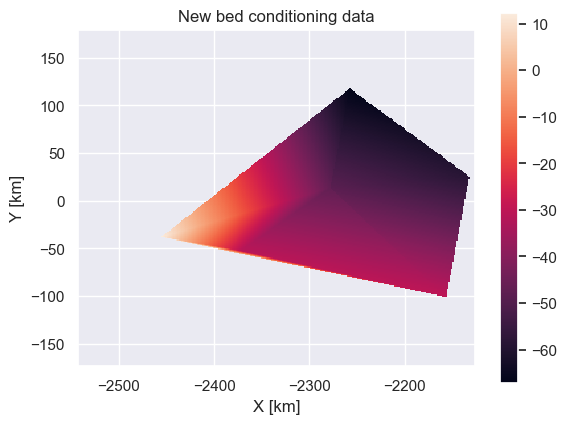

In [64]:
new_bed_cond = newcore_interpolated
plt.pcolormesh(x/1000, y/1000, new_bed_cond)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('New bed conditioning data')
plt.colorbar()
plt.show()

In [65]:
cond_msk = ~np.isnan(new_bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = new_bed_cond[cond_msk]

smoothing = 1e11
interp = RBFInterpolator(np.array([x_cond, y_cond]).T, data_cond, smoothing=smoothing)
new_trend = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
res_cond = new_bed_cond - new_trend

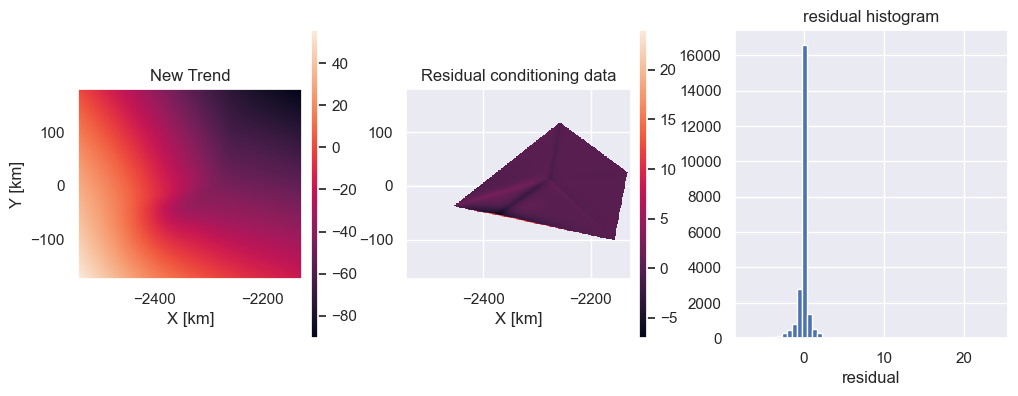

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
ax = axs[0]
im = ax.pcolormesh(x/1000, y/1000, new_trend)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('New Trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(x/1000, y/1000, res_cond)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Residual conditioning data')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
ax.hist(res_cond[cond_msk], bins=50)
ax.set_xlabel('residual')
ax.set_title('residual histogram')

plt.show()

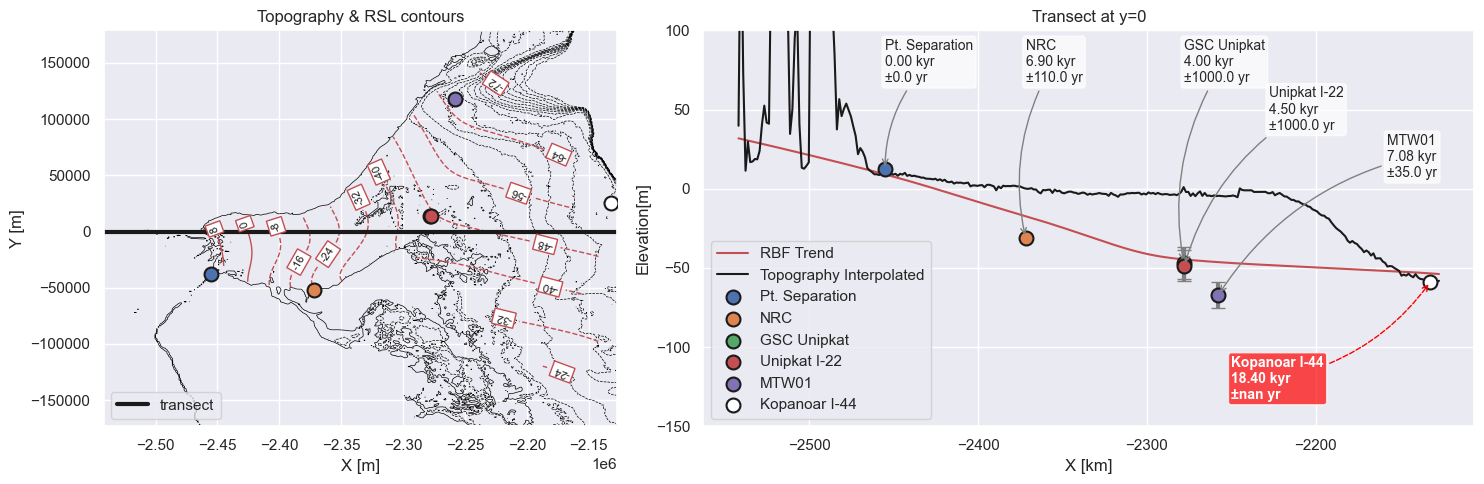

In [67]:
from matplotlib.gridspec import GridSpec

y0_idx = np.argmin(np.abs(y - 0))
transect_x = x  # x-coordinates
transect_rbf = new_trend[y0_idx, :]
transect_topo = topo_interpolated[y0_idx, :]

new_masked_trend = np.where(full_mask, new_trend, np.nan) 

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 2, width_ratios=[1, 1.5])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax = [ax0, ax1]

# Left subplot: topo_interpolated and RSL_interpolated contours
# im0 = ax[0].contourf(X, Y, topo_interpolated, 1000, cmap='Greys_r', vmin=vmin, vmax=vmax, zorder=1, alpha=0.5)
ax[0].contour(X, Y, topo_interpolated, levels=np.linspace(vmin, vmax, 15), colors='black', linewidths=0.5, zorder=2)
cs = ax[0].contour(X, Y, new_masked_trend, 10, colors='r',linewidths=1)
ax[0].axhline(0, color='k', linestyle='-', linewidth=3, label='transect')
ax[0].clabel(cs, fontsize=8, fmt='%1.0f', inline=True, colors='k', rightside_up=False)
for txt in cs.labelTexts:
    txt.set_bbox(dict(facecolor='white', edgecolor='r', pad=2))
ax[0].scatter(perimeter_cores['X'][6],perimeter_cores['Y'][6], zorder=3,edgecolor='k',facecolor='w', s=100,linewidth=1.5)
ax[0].set_title('Topography & RSL contours')
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].legend(loc='lower left')
# plt.colorbar(im0, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)

# Right subplot: transect at y=0
ax1 = ax[1]
ax1.plot(transect_x / 1000, transect_rbf, label='RBF Trend', c='r')
# ax1.plot(transect_x / 1000, transect_sgs_trend, label='RBF Trend + Gsim', c='pink')
# ax1.plot(transect_x / 1000, transect_sgs_trend_masked, label='RBF Trend + maskedGsim', c='pink', linestyle='--')
ax1.plot(transect_x / 1000, transect_topo, label='Topography Interpolated', c='k')
ax1.errorbar(core3_df['X']/1000, core3_df['depth_rsl'], yerr=core3_df['elevation_error'],
             ecolor='grey', elinewidth=3, fmt='o', capsize=5, zorder=1)
for i in range(5):
    ax1.scatter(core3_df['X'][i]/1000, core3_df['depth_rsl'][i], zorder=3, edgecolor='k', s=100, linewidth=1.5, label=core3_df['name'][i])
    ax[0].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='k', s=100,linewidth=1.5, label=core3_df['name'][i])
    if i <= 1:
        ax1.annotate(
            f"{core3_df['name'][i]}\n{core3_df['dated_year'][i]/1000:.2f} kyr\n±{core3_df['error'][i]:.1f} yr",
            xy=(core3_df['X'][i]/1000, core3_df['depth_rsl'][i]),
            xycoords='data',
            xytext=(core3_df['X'][i]/1000, 80),
            textcoords='data',
            fontsize=10,
            va="center", ha="left",
            bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.7),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='gray')
        )
    else:
        ax1.annotate(
            f"{core3_df['name'][i]}\n{core3_df['dated_year'][i]/1000:.2f} kyr\n±{core3_df['error'][i]:.1f} yr",
            xy=(core3_df['X'][i]/1000, core3_df['depth_rsl'][i]),
            xycoords='data',
            xytext=(core3_df['X'][i]/1000+(i-2)*50, 80-30*(i-2)),
            textcoords='data',
            fontsize=10,
            va="center", ha="left",
            bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.7),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='gray')
        )
ax1.scatter(perimeter_cores['X'][6]/1000,perimeter_cores['depth_rsl'][6], zorder=3,edgecolor='k',facecolor='w', s=100,linewidth=1.5, label=perimeter_cores['name'][6])
ax1.annotate(
    f"{perimeter_cores['name'][6]}\n{perimeter_cores['dated_year'][6]/1000:.2f} kyr\n±{perimeter_cores['dated_error'][6]:.1f} yr",
    xy=(perimeter_cores['X'][6]/1000, perimeter_cores['depth_rsl'][6]),
    xycoords='data',
    xytext=(-2250, -120),
    textcoords='data',
    fontsize=10,
    color='w',
    weight='bold',
    va="center", ha="left",
    bbox=dict(boxstyle="round,pad=0.2", fc="red", alpha=0.7),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='red', linestyle='--')
)
ax1.set_ylim(-150, 100)
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Elevation[m]')
ax1.set_title('Transect at y=0')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

In [73]:
fig.savefig("figures/offshore_constrained_transect.png", dpi=300, bbox_inches='tight')

In [70]:
new_trend_sediment_thickness = masked_topo_interpolated - new_masked_trend
new_trend_sediment_thickness = np.where(new_trend_sediment_thickness<0, np.nan,new_trend_sediment_thickness)

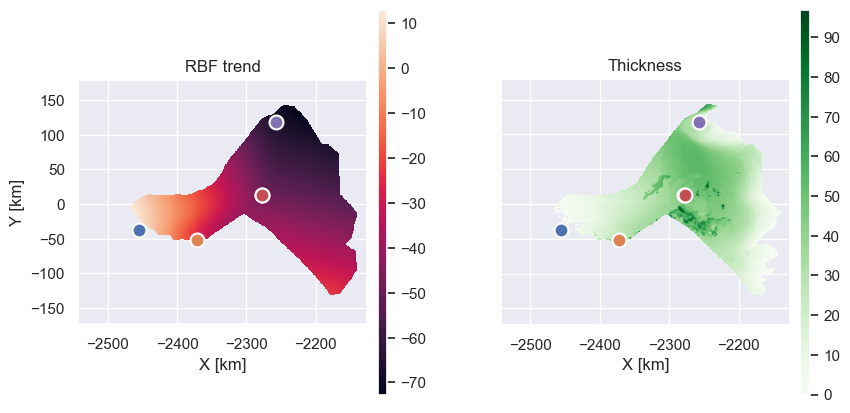

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1 = axs[0]
im = ax1.pcolormesh(x/1000, y/1000, new_masked_trend)
ax1.axis('scaled')
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_title('RBF trend')
plt.colorbar(im, ax=ax1, pad=0.03, aspect=40)

ax2 = axs[1]
im1 = ax2.contourf(x/1000, y/1000, new_trend_sediment_thickness, levels=100, cmap='Greens')

# ax2.plot(delta['X']/1000, delta['Y']/1000, color='green', linewidth=1)
# ax2.plot(offshore['X']/1000, offshore['Y']/1000, color='green', linewidth=1)
ax2.axis('scaled')
ax2.set_xlabel('X [km]')
ax2.set_title('Thickness')
for i in range(len(core3_df)):
    ax1.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax2.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])

plt.colorbar(im1, ax=ax2, pad=0.03, aspect=40)
plt.show()

# Reestimate Sediment Volume

In [72]:
new_V_estimated = np.nansum(new_trend_sediment_thickness)

print(f"V_total = {new_V_estimated} m^3")
print(f"Yearly sedimentation past 7.5KBP= {new_V_estimated/7500} m^3/yr")

V_total = 665988.8714802074 m^3
Yearly sedimentation past 7.5KBP= 88.798516197361 m^3/yr
